# Introduction

This notebook contains the process of developing a sophisticated Deep Learning (DL) model for predicting customer churn in the telecom industry.

This project is structured into three key phases:

1. Exploratory Data Analysis (EDA): Exploring the dataset to gain insights, helps understanding the foundation for building the models.
2. Data Preprocessing: Handling missing values, encode categorical features, and perform other necessary transformations.
3. Model Training and Evaluation: Building predictive models using Machine Learning (ML) algorithms as our baseline. Then building Deep Learning model for comparison through accuracy and classification reports.

# Import libraries

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    BatchNormalization,
    Activation,
    Input,
    Bidirectional,
    LSTM,
)
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.activations import swish
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import mlflow.keras
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import warnings
import joblib
import mlflow

# Configuration

In [2]:
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
mlflow.autolog()

2024/03/08 13:05:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/03/08 13:05:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2024/03/08 13:05:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/03/08 13:05:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


# Functions

In [3]:
# Plot accuracy and loss
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show()


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Loading data

In [4]:
df_master = pd.read_csv("../data/Train.csv")
df = df_master.copy()
df.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,NO,62,"Data:1000F=5GB,7d",11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,NO,11,Mixt 250F=Unlimited_call24H,2.0,0


# Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154048 entries, 0 to 2154047
Data columns (total 19 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         object 
 1   REGION          object 
 2   TENURE          object 
 3   MONTANT         float64
 4   FREQUENCE_RECH  float64
 5   REVENUE         float64
 6   ARPU_SEGMENT    float64
 7   FREQUENCE       float64
 8   DATA_VOLUME     float64
 9   ON_NET          float64
 10  ORANGE          float64
 11  TIGO            float64
 12  ZONE1           float64
 13  ZONE2           float64
 14  MRG             object 
 15  REGULARITY      int64  
 16  TOP_PACK        object 
 17  FREQ_TOP_PACK   float64
 18  CHURN           int64  
dtypes: float64(12), int64(2), object(5)
memory usage: 312.2+ MB


## Null Analysis

In [6]:
round(df.isna().sum().sort_values(ascending=False) / len(df), 4) * 100

ZONE2             93.65
ZONE1             92.12
TIGO              59.89
DATA_VOLUME       49.23
FREQ_TOP_PACK     41.90
TOP_PACK          41.90
ORANGE            41.56
REGION            39.43
ON_NET            36.52
MONTANT           35.13
FREQUENCE_RECH    35.13
REVENUE           33.71
ARPU_SEGMENT      33.71
FREQUENCE         33.71
REGULARITY         0.00
user_id            0.00
MRG                0.00
TENURE             0.00
CHURN              0.00
dtype: float64

## Categorical

In [7]:
cat_df_filled = df[["TOP_PACK", "REGION"]].fillna(value="Missing")

# Only show top 10
top_n = 10 

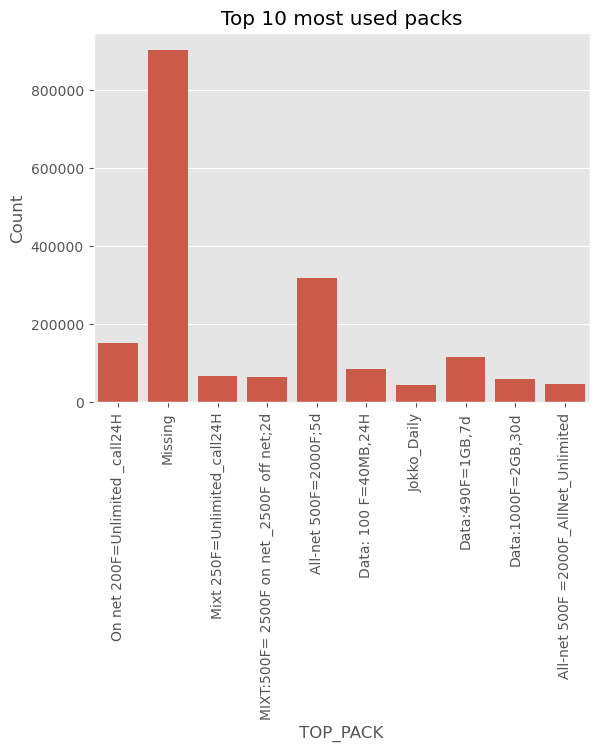

In [8]:
# Get the top values
top_packs = cat_df_filled['TOP_PACK'].value_counts(ascending=True).nlargest(top_n).index

# Filter
cat_df_top_n = cat_df_filled[cat_df_filled['TOP_PACK'].isin(top_packs)]

sns.countplot(data=cat_df_top_n, x="TOP_PACK")
plt.title("Top 10 most used packs")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

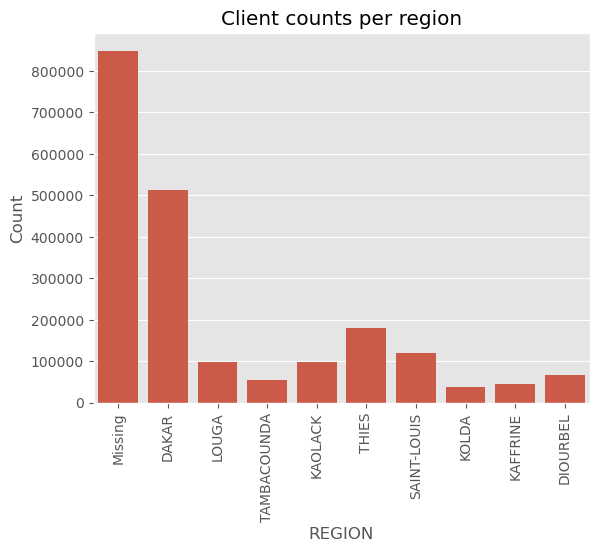

In [9]:
# Get the top values
top_region = cat_df_filled['REGION'].value_counts(ascending=True).nlargest(top_n).index

# Filter
cat_df_top_n = cat_df_filled[cat_df_filled['REGION'].isin(top_region)]

sns.countplot(data=cat_df_top_n, x="REGION")
plt.title("Client counts per region")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [10]:
df.MRG.unique()

array(['NO'], dtype=object)

## Numerical

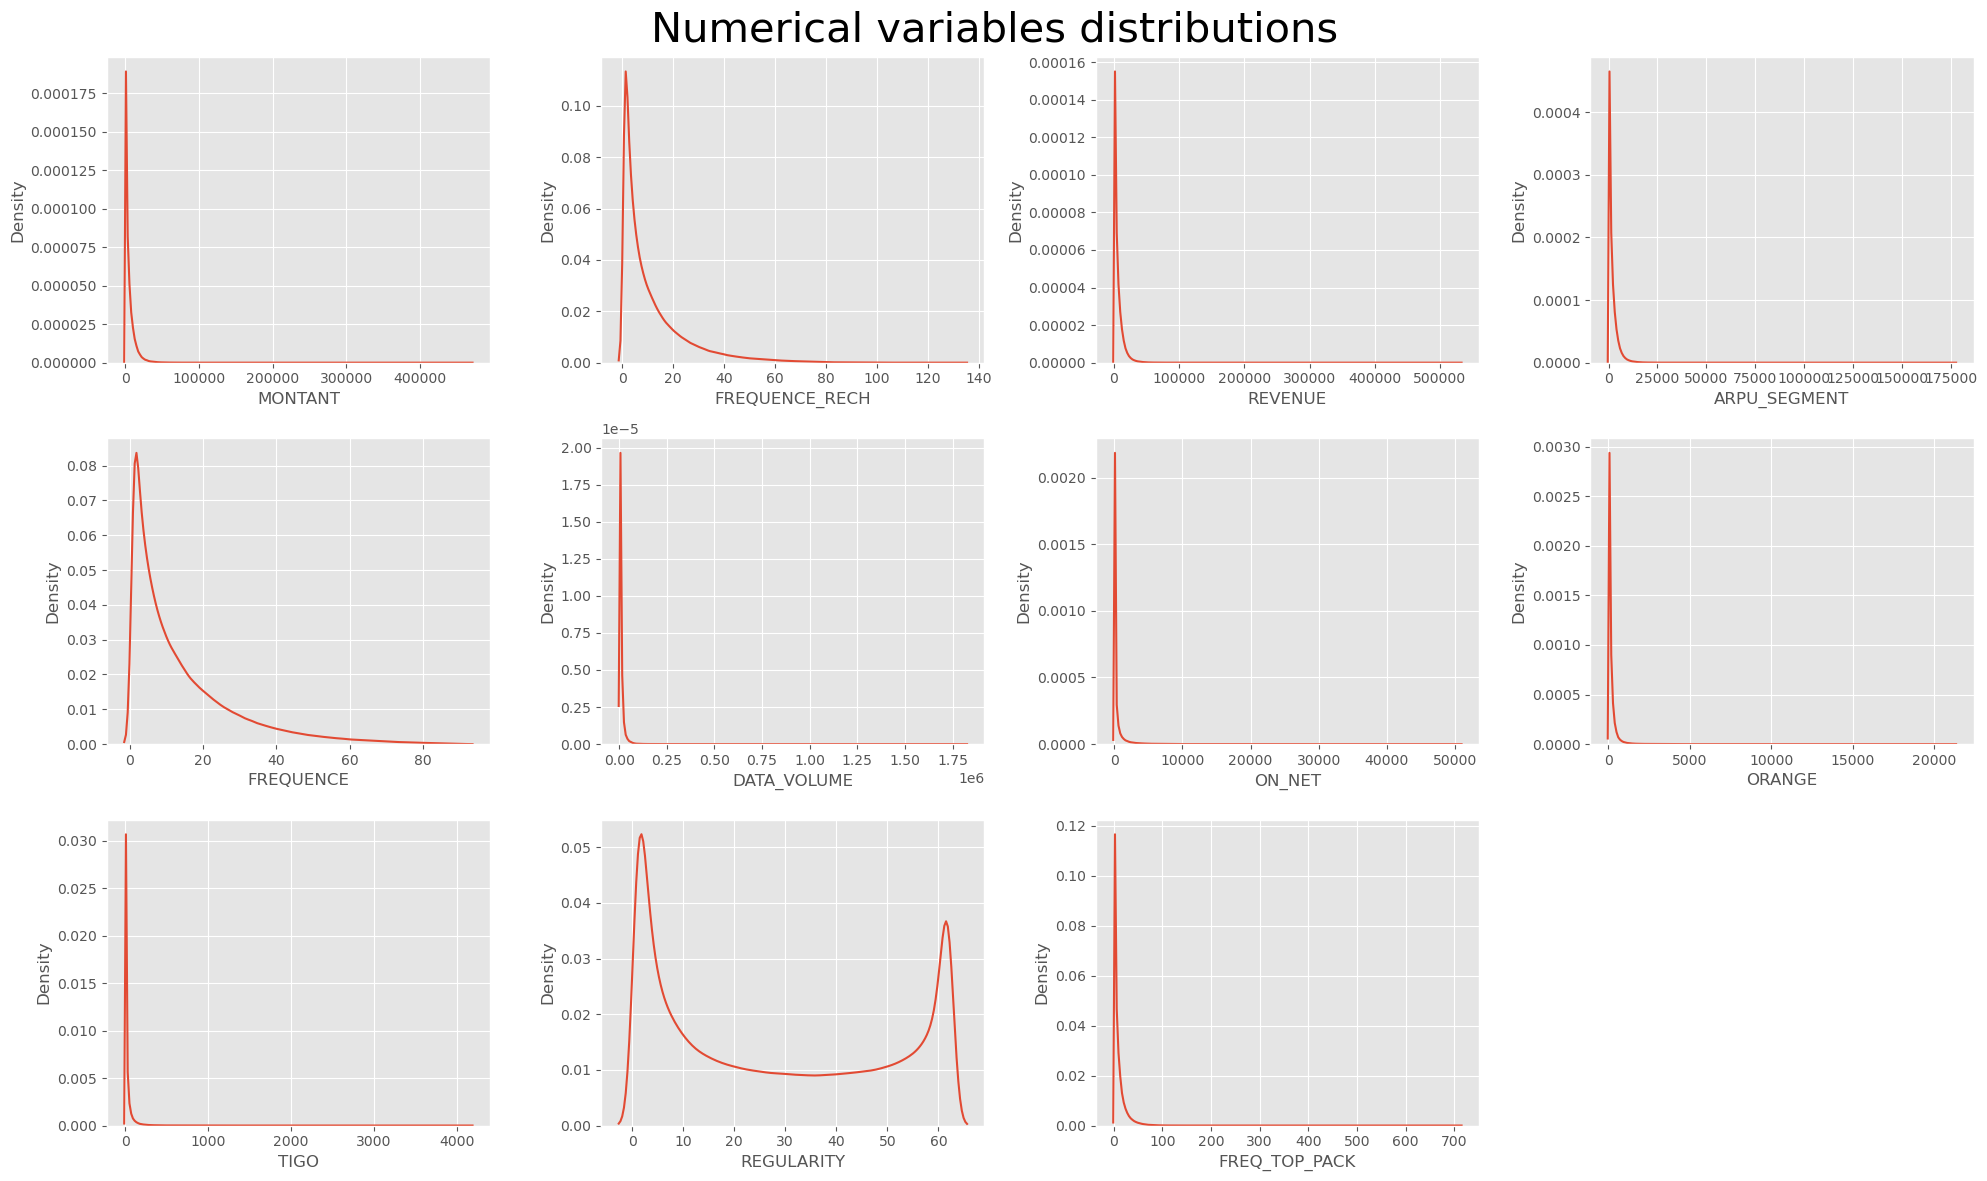

In [11]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes[2, 3].remove()  # Remove the empty subplot

sns.kdeplot(data=df, x="MONTANT", ax=axes[0, 0])
sns.kdeplot(data=df, x="FREQUENCE_RECH", ax=axes[0, 1])
sns.kdeplot(data=df, x="REVENUE", ax=axes[0, 2])
sns.kdeplot(data=df, x="ARPU_SEGMENT", ax=axes[0, 3])

sns.kdeplot(data=df, x="FREQUENCE", ax=axes[1, 0])
sns.kdeplot(data=df, x="DATA_VOLUME", ax=axes[1, 1])
sns.kdeplot(data=df, x="ON_NET", ax=axes[1, 2])
sns.kdeplot(data=df, x="ORANGE", ax=axes[1, 3])

sns.kdeplot(data=df, x="TIGO", ax=axes[2, 0])
sns.kdeplot(data=df, x="REGULARITY", ax=axes[2, 1])
sns.kdeplot(data=df, x="FREQ_TOP_PACK", ax=axes[2, 2])

plt.suptitle("Numerical variables distributions", fontsize=30)
plt.tight_layout()
plt.show()

## Target

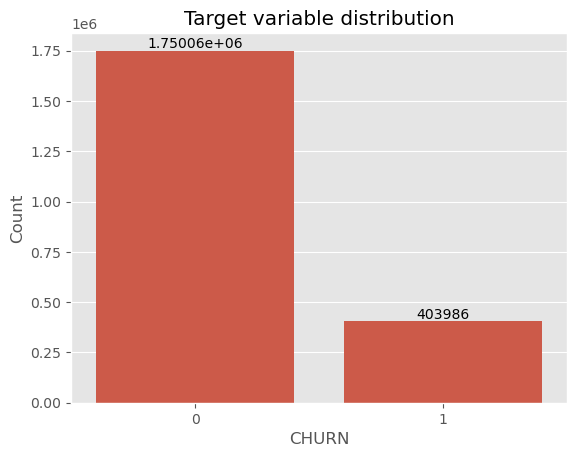

In [12]:
ax = sns.countplot(data=df, x="CHURN")
ax.bar_label(ax.containers[0]) # Display the count numbers

plt.title("Target variable distribution")
plt.ylabel("Count")
plt.show()

> Comments: The target variable shows an imbalance distribution case. All the numerical variables are right-skewed. There are lots of null values in most of the features.

# Data preprocessing

In this step, the chosen approach for preparing the data are:

* Dropping null columns with more than 80%.
* Filling null values, with categorical it's "Missing" and with numerical it's "Median".
* Encoding categorical variables with one-hot encoding.
* Normalizing numerical variables with StandardScaler.


## Splitting dataset

In [13]:
X = df.drop(["user_id", "MRG", "ZONE1", "ZONE2", "CHURN"], axis=1)
y = df.CHURN

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, stratify=y, shuffle=True, random_state=42
)
print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")

Train size: (2046345, 14)
Test size: (107703, 14)


## Preprocessing

In [15]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        # Impute missing values in categorical columns and then apply one-hot encoding
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols),
        # Impute missing values in numerical columns and then apply scaling
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols)
    ], remainder='passthrough')

X_train_processed = preprocessor.fit_transform(X_train)
joblib.dump(preprocessor, 'preprocessor.joblib')
X_test_processed = preprocessor.transform(X_test)

2024/03/08 13:05:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3be52ba134c2499db50f86bcbe5aac77', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/03/08 13:05:40 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2024/03/08 13:05:41 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/03/08 13:05:41 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byter

In [16]:
""" Resampling
oversampling = SMOTE(random_state=42, k_neighbors=3, n_jobs=-1)
X_resampled, y_resampled = oversampling.fit_resample(X_train_processed, y_train)

print(f'Size after resampling: {X_resampled.shape}')
print(f'Size before resampling: {X_train_processed.shape}')
"""

" Resampling\noversampling = SMOTE(random_state=42, k_neighbors=3, n_jobs=-1)\nX_resampled, y_resampled = oversampling.fit_resample(X_train_processed, y_train)\n\nprint(f'Size after resampling: {X_resampled.shape}')\nprint(f'Size before resampling: {X_train_processed.shape}')\n"

# Model Training

As discussed earlier, the traditional ML will be our baseline, here we chose the popular algorithms such as Random Forest, XGBoost.

## Traditional

In [17]:
xgb = XGBClassifier(n_jobs=-1)
#xgb.fit(X_resampled, y_resampled)
xgb.fit(X_train_processed, y_train)
y_pred_xgb = xgb.predict(X_test_processed)

2024/03/08 13:05:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b79cb5f688184726bf1944f275cf8b7f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


In [18]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
#rf.fit(X_resampled, y_resampled)
rf.fit(X_train_processed, y_train)
y_pred_rf = rf.predict(X_test_processed)

2024/03/08 13:06:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '664f0593cc3f4a128c3db2b9a1fb639b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/03/08 13:06:19 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


In [19]:
acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
rec_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

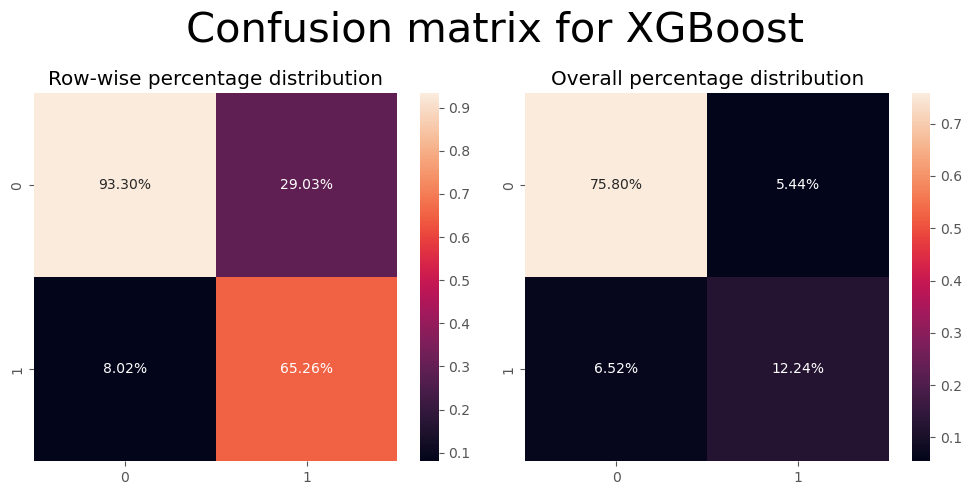

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_xgb_perc = cm_xgb / cm_xgb.sum(axis=1)

sns.heatmap(cm_xgb_perc, annot=True, fmt='.2%', ax=axes[0])
axes[0].set_title("Row-wise percentage distribution")
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='all'), annot=True, fmt='.2%', ax=axes[1])
axes[1].set_title("Overall percentage distribution")

plt.suptitle("Confusion matrix for XGBoost", fontsize=30)
plt.tight_layout()
plt.show()

In [21]:
print(f'Accuracy: {acc_xgb}')
print(f'Precision: {prec_xgb}')
print(f'Recall: {rec_xgb}')
print(f'F1: {f1_xgb}')

Accuracy: 0.8804025886001319
Precision: 0.6921340054610376
Recall: 0.6525570572800634
F1: 0.6717631169890173


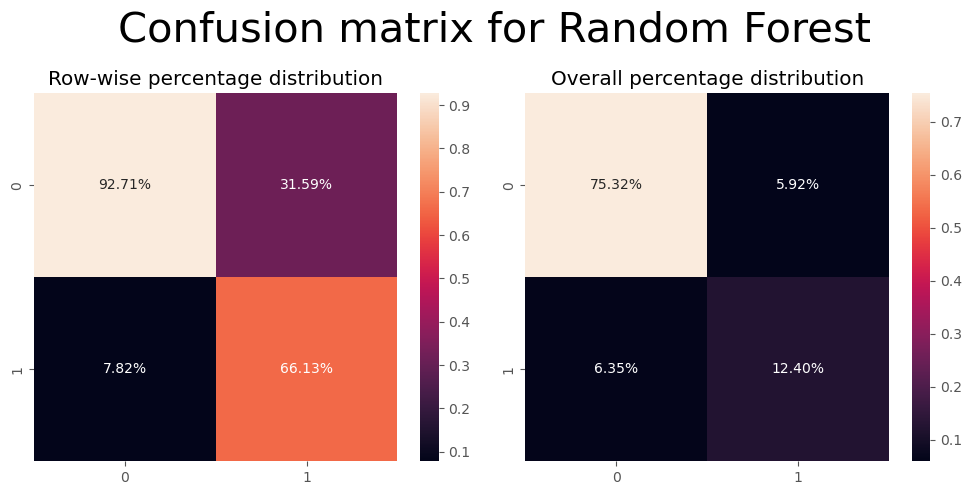

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf_perc = cm_rf / cm_rf.sum(axis=1)

sns.heatmap(cm_rf_perc, annot=True, fmt='.2%', ax=axes[0])
axes[0].set_title("Row-wise percentage distribution")
sns.heatmap(confusion_matrix(y_test, y_pred_rf, normalize='all'), annot=True, fmt='.2%', ax=axes[1])
axes[1].set_title("Overall percentage distribution")

plt.suptitle("Confusion matrix for Random Forest", fontsize=30)
plt.tight_layout()
plt.show()

In [23]:
print(f'Accuracy: {acc_rf}')
print(f'Precision: {prec_rf}')
print(f'Recall: {rec_rf}')
print(f'F1: {f1_rf}')

Accuracy: 0.8772364743786153
Precision: 0.6767492526726453
Recall: 0.6612703599188079
F1: 0.6689202724358975


> Comments: The baseline models performed well with a good accuracy but not able to have a good prediction on the label "churned".

## Deep learning

We will build an ensemble model with the combination of a DNN and an Bidirectional LSTM.

In [24]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

### DNN

In [25]:
def dnn_run(params):
    with mlflow.start_run(run_name=f"DNN Training - Dense={params['Dense']}, Epochs={params['epochs']}") as run:
        dnn = Sequential()

        # Input layer
        dnn.add(Dense(params["Dense"], input_dim=X_train_processed.shape[1], activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001)))
        dnn.add(BatchNormalization())

        # Hidden layers
        dnn.add(Dense((params["Dense"]/2), activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001)))
        dnn.add(Dropout(0.5))  
        dnn.add(BatchNormalization())

        dnn.add(Dense((params["Dense"]/2/2), activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001)))
        dnn.add(Dropout(0.5))  
        dnn.add(BatchNormalization())

        # Output layer
        dnn.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

        dnn.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
        )

        with tf.device('/cpu:0'):
            r = dnn.fit(X_train_processed, y_train, epochs=params["epochs"], batch_size=128, validation_split=0.05, callbacks=[early_stopping])

        return (r, run.info.run_id, run.info.experiment_id)

2024/03/08 13:15:05 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/10
15188/15188 [==============================] - 24s 2ms/step - loss: 0.2939 - accuracy: 0.8661 - val_loss: 0.2653 - val_accuracy: 0.8761
Epoch 2/10
15188/15188 [==============================] - 19s 1ms/step - loss: 0.2789 - accuracy: 0.8701 - val_loss: 0.2608 - val_accuracy: 0.8767
Epoch 3/10
15188/15188 [==============================] - 21s 1ms/step - loss: 0.2789 - accuracy: 0.8699 - val_loss: 0.2598 - val_accuracy: 0.8781
Epoch 4/10
15188/15188 [==============================] - 22s 1ms/step - loss: 0.2787 - accuracy: 0.8701 - val_loss: 0.2603 - val_accuracy: 0.8783
Epoch 5/10
15188/15188 [==============================] - 20s 1ms/step - loss: 0.2788 - accuracy: 0.8700 - val_loss: 0.2593 - val_accuracy: 0.8783
Epoch 6/10
15188/15188 [==============================] - 18s 1ms/step - loss: 0.2785 - accuracy: 0.8701 - val_loss: 0.2593 - val_accuracy: 0.8784
Epoch 7/10
15188/15188 [==============================] - 20s 1ms/step - loss: 0.2788 - accuracy: 0.8702 - val_loss: 0

INFO:tensorflow:Assets written to: /var/folders/nx/nd5hy9z92p18k3jpbyyqw3m80000gn/T/tmprbzy4uhv/model/data/model/assets


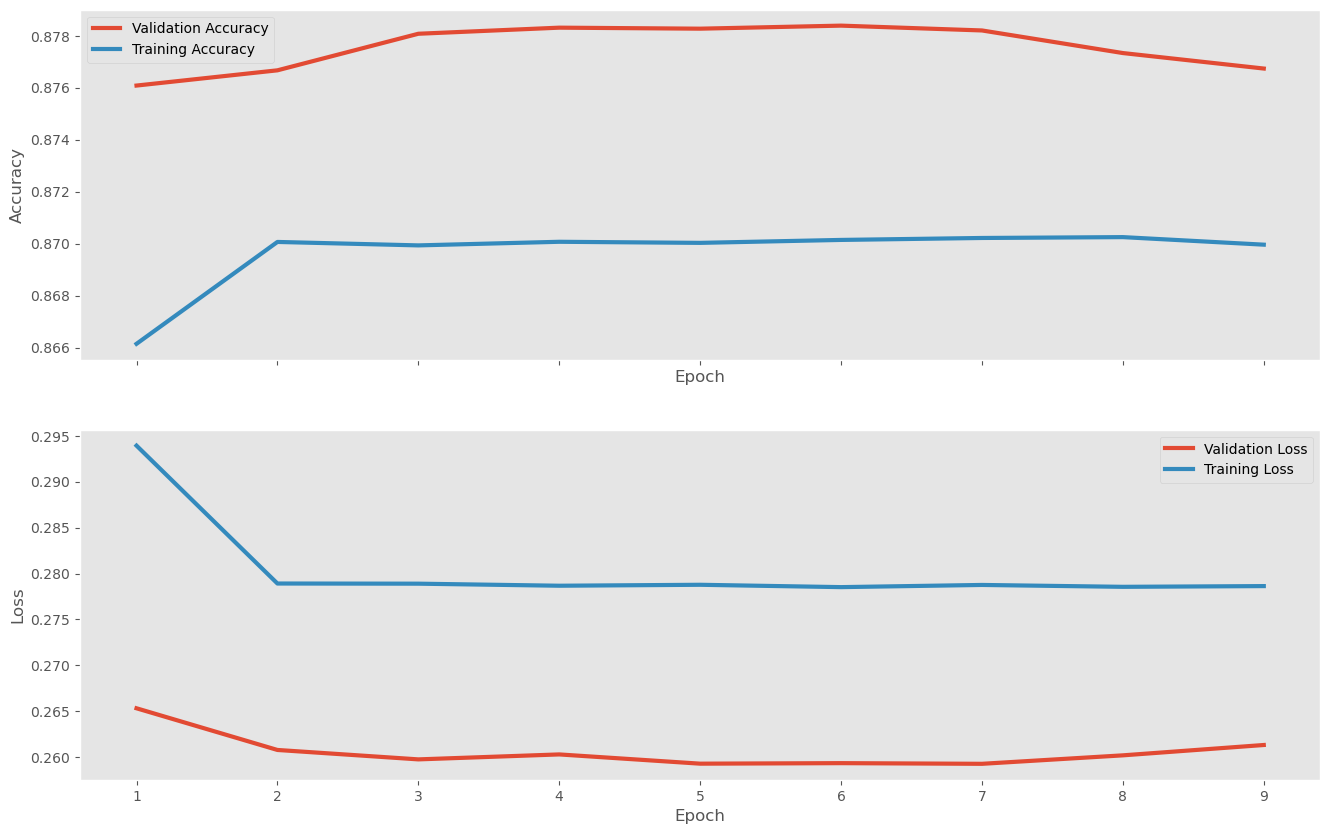

Run ID: d0614d80956948c483bc8e4db4253e26
Experiment ID: 800289584898755491


2024/03/08 13:18:23 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/20
    1/15188 [..............................] - ETA: 2:26:02 - loss: 1.3251 - accuracy: 0.5312WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0014s vs `on_train_batch_end` time: 0.0030s). Check your callbacks.


15188/15188 [==============================] - 24s 2ms/step - loss: 0.2941 - accuracy: 0.8700 - val_loss: 0.2623 - val_accuracy: 0.8767
Epoch 2/20
15188/15188 [==============================] - 28s 2ms/step - loss: 0.2764 - accuracy: 0.8716 - val_loss: 0.2620 - val_accuracy: 0.8768
Epoch 3/20
15188/15188 [==============================] - 24s 2ms/step - loss: 0.2760 - accuracy: 0.8710 - val_loss: 0.2600 - val_accuracy: 0.8776
Epoch 4/20
15188/15188 [==============================] - 26s 2ms/step - loss: 0.2760 - accuracy: 0.8707 - val_loss: 0.2582 - val_accuracy: 0.8783
Epoch 5/20
15188/15188 [==============================] - 24s 2ms/step - loss: 0.2766 - accuracy: 0.8702 - val_loss: 0.2583 - val_accuracy: 0.8784
Epoch 6/20
15188/15188 [==============================] - 24s 2ms/step - loss: 0.2764 - accuracy: 0.8702 - val_loss: 0.2694 - val_accuracy: 0.8555
Epoch 7/20
15188/15188 [==============================] - 28s 2ms/step - loss: 0.2763 - accuracy: 0.8702 - val_loss: 0.2635 - val

INFO:tensorflow:Assets written to: /var/folders/nx/nd5hy9z92p18k3jpbyyqw3m80000gn/T/tmppvuzclpf/model/data/model/assets


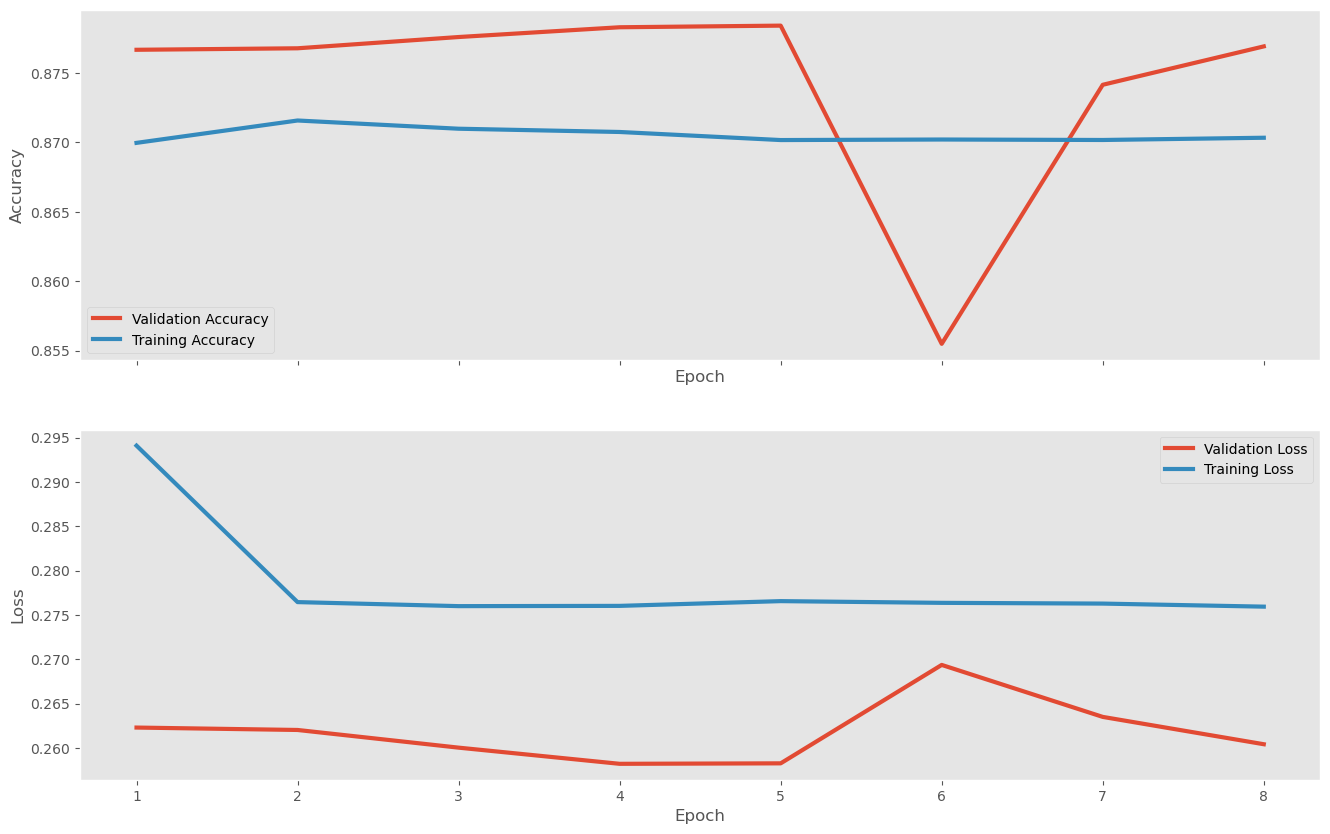

Run ID: cab36fdffad74ef78c6d9b9d06129f7c
Experiment ID: 800289584898755491


2024/03/08 13:22:29 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/30
15188/15188 [==============================] - 81s 5ms/step - loss: 0.2966 - accuracy: 0.8728 - val_loss: 0.2625 - val_accuracy: 0.8782
Epoch 2/30
15188/15188 [==============================] - 50s 3ms/step - loss: 0.2728 - accuracy: 0.8741 - val_loss: 0.2610 - val_accuracy: 0.8779
Epoch 3/30
15188/15188 [==============================] - 44s 3ms/step - loss: 0.2722 - accuracy: 0.8741 - val_loss: 0.2607 - val_accuracy: 0.8778
Epoch 4/30
15188/15188 [==============================] - 46s 3ms/step - loss: 0.2719 - accuracy: 0.8742 - val_loss: 0.2607 - val_accuracy: 0.8782
Epoch 5/30
15188/15188 [==============================] - 31s 2ms/step - loss: 0.2718 - accuracy: 0.8743 - val_loss: 0.2618 - val_accuracy: 0.8769
Epoch 6/30
15188/15188 [==============================] - 30s 2ms/step - loss: 0.2715 - accuracy: 0.8747 - val_loss: 0.2598 - val_accuracy: 0.8779
Epoch 7/30
1/1 [==============================] - 0s 56ms/step
INFO:tensorflow:Assets written to: /var/folders/nx/nd5h

INFO:tensorflow:Assets written to: /var/folders/nx/nd5hy9z92p18k3jpbyyqw3m80000gn/T/tmpgi1v4i4x/model/data/model/assets


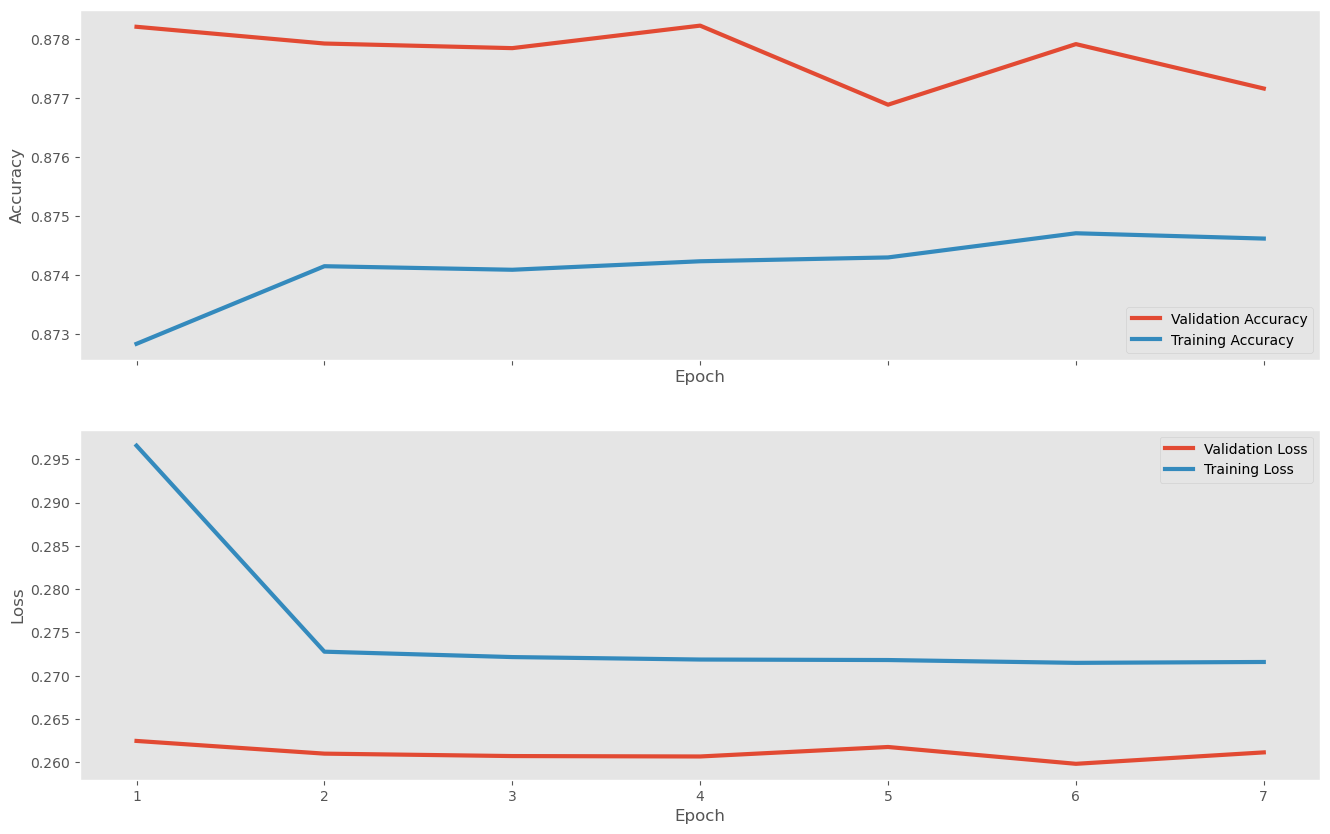

Run ID: 9613346220fe486a8dec7566cab33fb8
Experiment ID: 800289584898755491


2024/03/08 13:27:55 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/50
    1/15188 [..............................] - ETA: 2:16:24 - loss: 2.5948 - accuracy: 0.5703WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0030s vs `on_train_batch_end` time: 0.0031s). Check your callbacks.


15188/15188 [==============================] - 57s 4ms/step - loss: 0.3032 - accuracy: 0.8733 - val_loss: 0.2652 - val_accuracy: 0.8767
Epoch 2/50
15188/15188 [==============================] - 99s 7ms/step - loss: 0.2707 - accuracy: 0.8749 - val_loss: 0.2595 - val_accuracy: 0.8780
Epoch 3/50
15188/15188 [==============================] - 109s 7ms/step - loss: 0.2701 - accuracy: 0.8746 - val_loss: 0.2605 - val_accuracy: 0.8783
Epoch 4/50
15188/15188 [==============================] - 101s 7ms/step - loss: 0.2701 - accuracy: 0.8745 - val_loss: 0.2598 - val_accuracy: 0.8784
Epoch 5/50
15188/15188 [==============================] - 123s 8ms/step - loss: 0.2698 - accuracy: 0.8746 - val_loss: 0.2619 - val_accuracy: 0.8759
Epoch 6/50
15188/15188 [==============================] - 94s 6ms/step - loss: 0.2696 - accuracy: 0.8747 - val_loss: 0.2599 - val_accuracy: 0.8780
Epoch 7/50
1/1 [==============================] - 0s 89ms/step
INFO:tensorflow:Assets written to: /var/folders/nx/nd5hy9z92p18

INFO:tensorflow:Assets written to: /var/folders/nx/nd5hy9z92p18k3jpbyyqw3m80000gn/T/tmp5ry7ch9l/model/data/model/assets


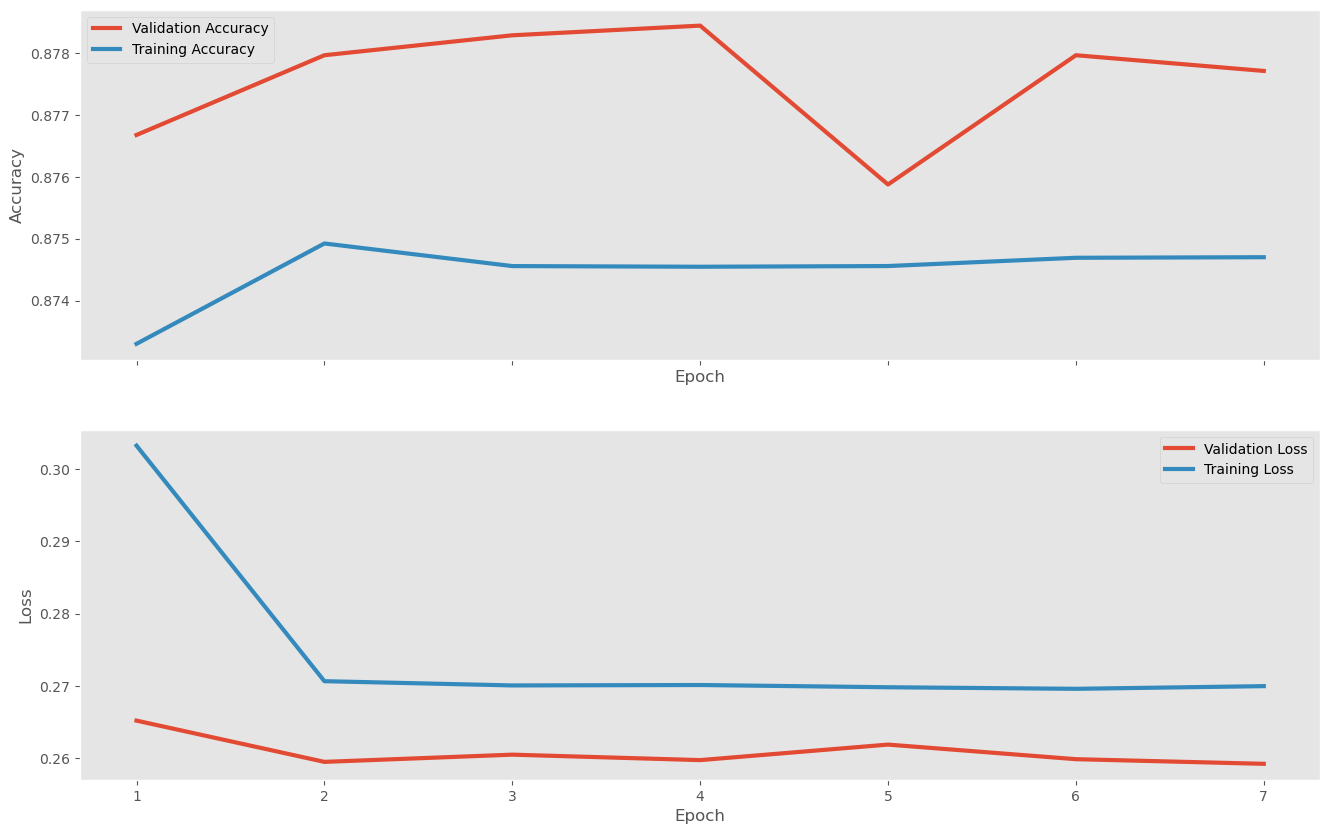

Run ID: 89d2e8b060c740b2b09d509ea772328f
Experiment ID: 800289584898755491


In [26]:
#mlflow.end_run() # End any current runs
mlflow.set_experiment("Churn_prediction_with_DNN")

for epochs, dense in zip([10, 20, 30, 50], [64, 128, 256, 512]):
    params = {
        "epochs": epochs,
        "Dense": dense
    }
    results = dnn_run(params)
    plot_results(results[0])
    print(f"Run ID: {results[1]}")
    print(f"Experiment ID: {results[2]}")

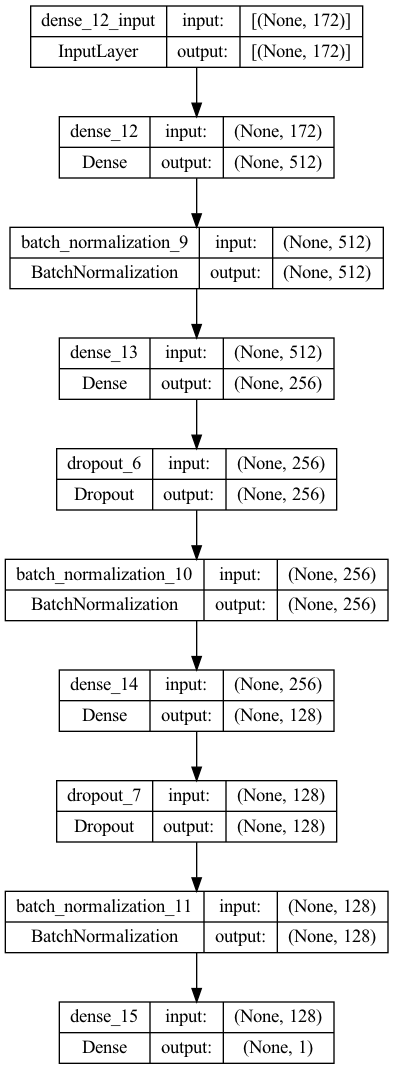

In [27]:
best_dnn_run = mlflow.search_runs(order_by=["metrics.f1_m DESC"]).iloc[0]
best_dnn_run_id = best_dnn_run.run_id
best_dnn_uri = f"runs:/{best_dnn_run_id}/model"

best_dnn = mlflow.tensorflow.load_model(best_dnn_uri)
plot_model(best_dnn, to_file="../dnn.png", show_shapes=True)

In [78]:
best_dnn.save("../models/dnn.h5")

3366/3366 [==============================] - 2s 481us/step


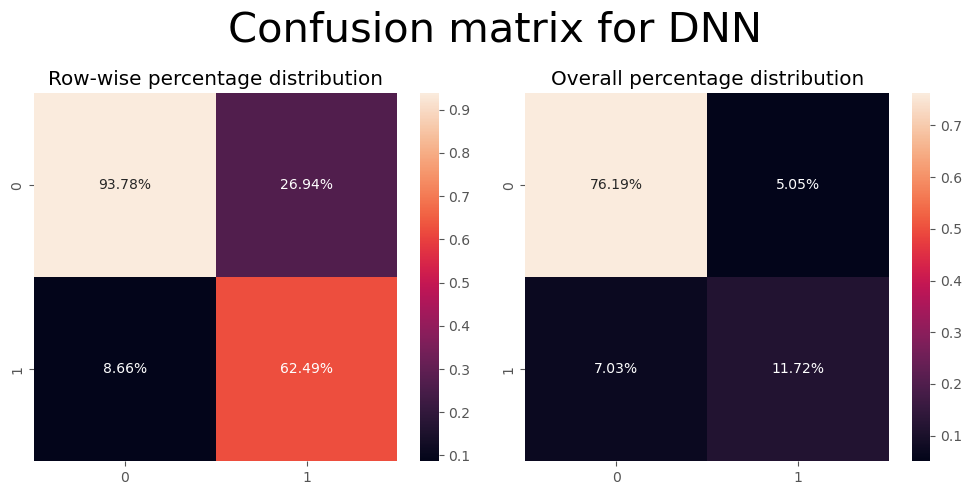

In [29]:
y_pred_dnn = best_dnn.predict(X_test_processed)
y_pred_dnn_bin = (y_pred_dnn > 0.5).astype(
    "int32"
)  # Default threshold is 0.5, but change be change

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

cm_dnn = confusion_matrix(y_test, y_pred_dnn_bin)
cm_dnn_perc = cm_dnn / cm_dnn.sum(axis=1)

sns.heatmap(cm_dnn_perc, annot=True, fmt=".2%", ax=axes[0])
axes[0].set_title("Row-wise percentage distribution")
sns.heatmap(
    confusion_matrix(y_test, y_pred_dnn_bin, normalize="all"),
    annot=True,
    fmt=".2%",
    ax=axes[1],
)
axes[1].set_title("Overall percentage distribution")

plt.suptitle("Confusion matrix for DNN", fontsize=30)
plt.tight_layout()
plt.show()

In [30]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_dnn_bin)}")
print(f"Precision: {precision_score(y_test, y_pred_dnn_bin)}")
print(f"Recall: {recall_score(y_test, y_pred_dnn_bin)}")
print(f"F1: {f1_score(y_test, y_pred_dnn_bin)}")

Accuracy: 0.8791305720360622
Precision: 0.6987544976473844
Recall: 0.6249319273231349
F1: 0.659784653982856


### RNN

In [34]:
def rnn_run(params):
    with mlflow.start_run(
        run_name=f"RNN Training - Units={params['unit']}, Epochs={params['epochs']}"
    ) as run:
        rnn = Sequential()

        rnn.add(
            Bidirectional(
                LSTM(units=params["unit"], return_sequences=True),
                input_shape=(X_train_processed.shape[1], 1),
            )
        )
        # rnn.add(Activation(swish))
        rnn.add(Dropout(0.5))

        #rnn.add(Bidirectional(LSTM(units=params["unit"], return_sequences=True)))
        # rnn.add(Activation(swish))
        #rnn.add(Dropout(0.5))
        rnn.add(BatchNormalization())

        # Output layer for binary classification
        rnn.add(Dense(1, activation="sigmoid"))

        rnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

        with tf.device("/cpu:0"):
            r = rnn.fit(
                X_train_processed,
                y_train,
                epochs=params["epochs"],
                batch_size=128,
                validation_split=0.05,
                callbacks=[early_stopping],
            )
        
        return (r, run.info.run_id, run.info.experiment_id)

In [35]:
mlflow.set_experiment("Churn_prediction_with_RNN")

for epochs, units in zip([10, 20, 30, 50], [2, 4, 8]):
    params = {
        "epochs": epochs,
        "unit": dense
    }
    results = rnn_run(params)
    plot_results(results[0])
    print(f"Run ID: {results[1]}")
    print(f"Experiment ID: {results[2]}")

2024/03/08 15:02:38 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/10
   17/15188 [..............................] - ETA: 6:13:28 - loss: 0.6169 - accuracy: 0.7383

KeyboardInterrupt: 

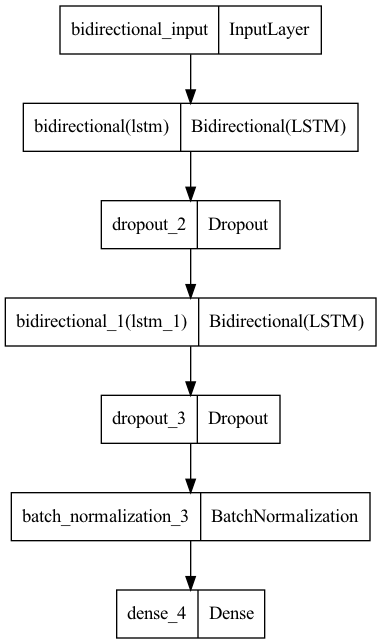

In [54]:
plot_model(rnn, to_file="../rnn.png")

In [57]:
rnn.save("../models/rnn.h5")

3366/3366 [==============================] - 27s 8ms/step


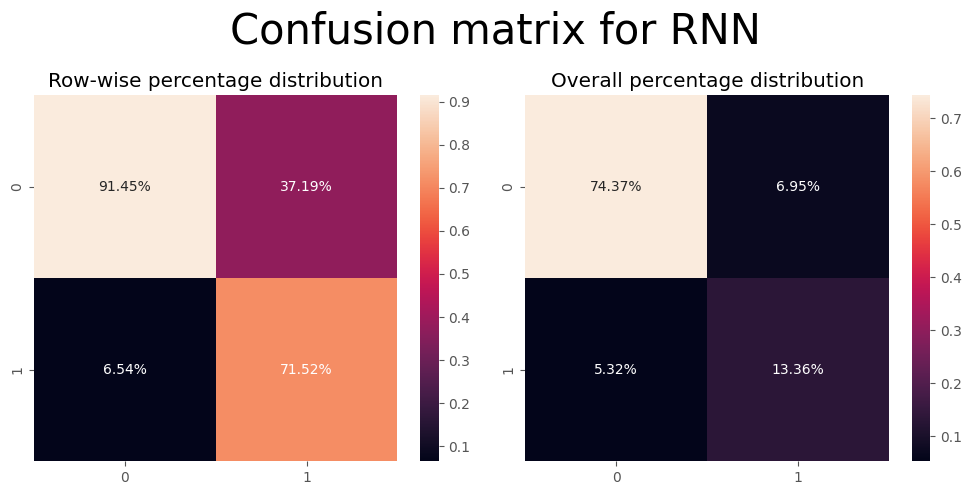

3366/3366 [==============================] - 33s 10ms/step - loss: 0.2568 - accuracy: 0.8780
RNN: Loss is 0.2567703127861023, Accuracy is 0.8779556155204773


In [58]:
load_rnn = load_model("../models/rnn.h5")
y_pred_rnn = load_rnn.predict(X_test_processed)
y_pred_rnn_bin = []

for i in y_pred_rnn:
  if (i > 0.5).any():
     y_pred_rnn_bin.append(1)
  else:
     y_pred_rnn_bin.append(0)

cm_rnn = confusion_matrix(y_test, y_pred_rnn_bin)
cm_rnn_perc = cm_rnn / cm_rnn.sum(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(cm_rnn_perc, annot=True, fmt='.2%', ax=axes[0])
axes[0].set_title("Row-wise percentage distribution")
sns.heatmap(confusion_matrix(y_test, y_pred_rnn_bin, normalize='all'), annot=True, fmt='.2%', ax=axes[1])
axes[1].set_title("Overall percentage distribution")

plt.suptitle("Confusion matrix for RNN", fontsize=30)
plt.tight_layout()
plt.show()

loss_2, accuracy_2, precision_2, recall_2, f1_2 = load_rnn.evaluate(X_test_processed, y_test)
print(f"RNN: \nLoss is {loss_2}, \nAccuracy is {accuracy_2}, \nPrecision is {precision_2}, \nRecall is {recall_2}, \nF1 is {f1_2}")

### Ensemble model

In [6]:
# DNN
input_dnn = Input(shape=(X_train_processed.shape[1],))
x_dnn = Dense(1024, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001))(input_dnn)

x_dnn = Dense(512, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001))(x_dnn)
x_dnn = Dropout(0.5)(x_dnn)

x_dnn = Dense(256, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001))(x_dnn)
x_dnn = Dropout(0.5)(x_dnn)

x_dnn = Dense(64, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001))(x_dnn)
x_dnn = Dropout(0.5)(x_dnn)
x_dnn = BatchNormalization()(x_dnn)

# RNN
input_rnn = Input(shape=(X_train_processed.shape[1], 1))
x_rnn = Bidirectional(LSTM(units=8, return_sequences=True))(input_rnn)
x_rnn = Activation(swish)(x_rnn)
x_rnn = Dropout(0.5)(x_rnn)

x_rnn = Bidirectional(LSTM(units=8, return_sequences=True))(input_rnn)
x_rnn = Activation(swish)(x_rnn)
x_rnn = Dropout(0.5)(x_rnn)

x_rnn = Bidirectional(LSTM(units=8, return_sequences=False))(x_rnn)
x_rnn = Activation(swish)(x_rnn)
x_rnn = Dropout(0.5)(x_rnn)
x_rnn = BatchNormalization()(x_rnn)

# Concat
combined = concatenate([x_dnn, x_rnn])

# Output layer for binary classification
output = Dense(1, activation='sigmoid')(combined)

In [7]:
ensemble_model = Model(inputs=[input_dnn, input_rnn], outputs=output)
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 175)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 1024)                 180224    ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 175, 1)]             0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 512)                  524800    ['dense[0][0]']               
                                                                                              

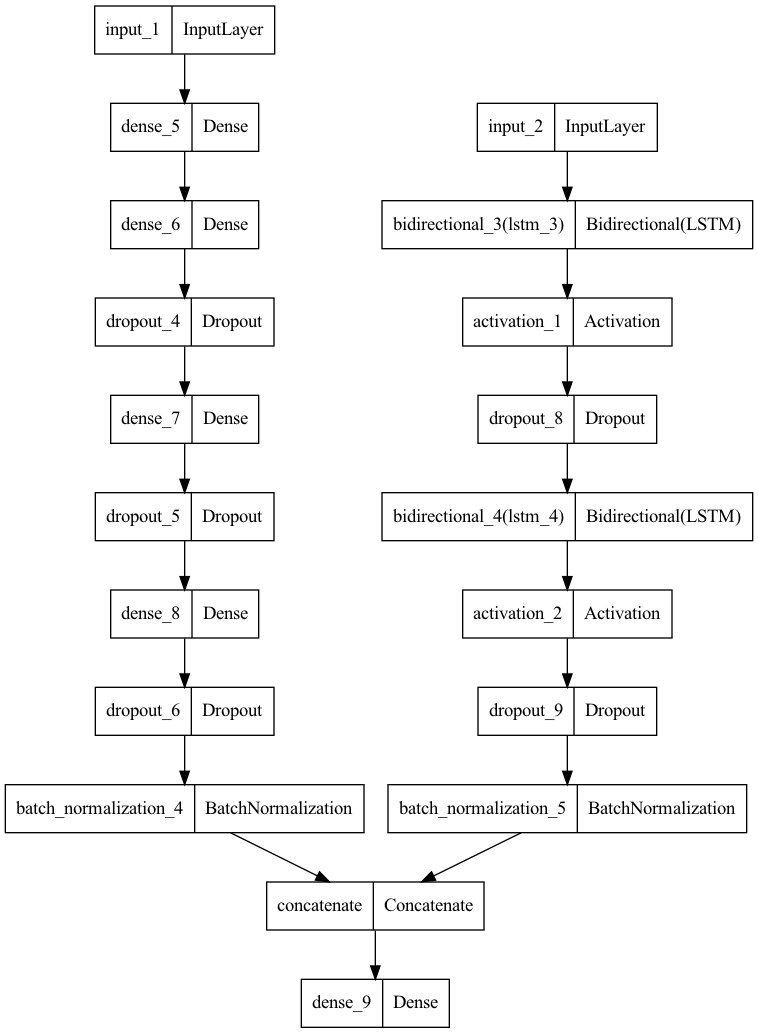

In [61]:
plot_model(ensemble_model, to_file="../ensemble.png")

In [11]:
optimizer = Adam(learning_rate=0.001)

ensemble_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
with tf.device('/cpu:0'):
    history_ens = ensemble_model.fit([X_train_processed, X_train_processed], y_train, epochs=10, batch_size=128, validation_split=0.05, callbacks=[early_stopping])

Epoch 1/10
15188/15188 [==============================] - 1136s 75ms/step - loss: 0.3095 - accuracy: 0.8733 - val_loss: 0.2654 - val_accuracy: 0.8772
Epoch 2/10
15188/15188 [==============================] - 1001s 66ms/step - loss: 0.2715 - accuracy: 0.8742 - val_loss: 0.2668 - val_accuracy: 0.8732
Epoch 3/10
15188/15188 [==============================] - 907s 60ms/step - loss: 0.2693 - accuracy: 0.8746 - val_loss: 0.2628 - val_accuracy: 0.8765
Epoch 4/10
15188/15188 [==============================] - 873s 58ms/step - loss: 0.2691 - accuracy: 0.8746 - val_loss: 0.2643 - val_accuracy: 0.8751


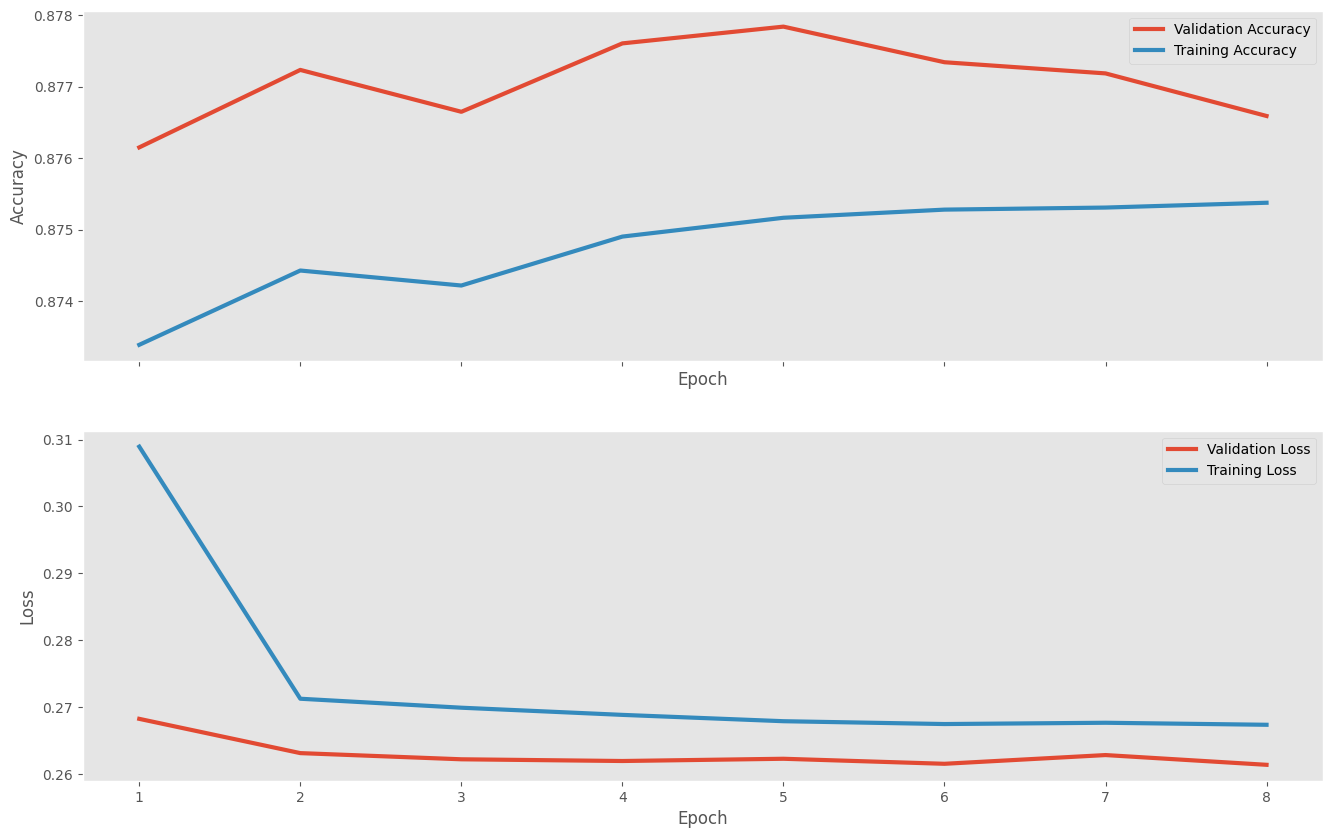

In [64]:
plot_results(history_ens)

In [13]:
ensemble_model.save("../models/ensemble.h5")
load_ens = load_model("../models/ensemble.h5")

3366/3366 [==============================] - 31s 9ms/step


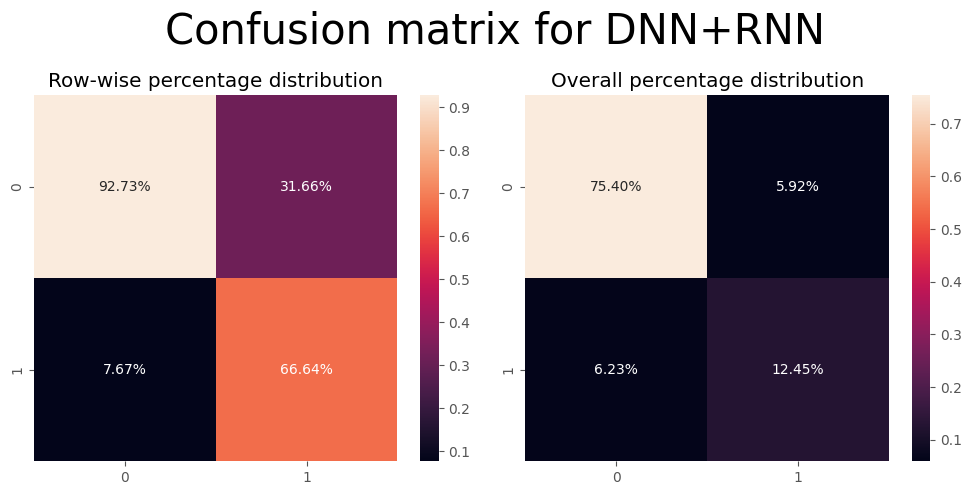

3366/3366 [==============================] - 32s 9ms/step - loss: 0.2582 - accuracy: 0.8785
Ensemble: Loss is 0.25821641087532043, Accuracy is 0.878517746925354


In [66]:
y_pred_ens = load_ens.predict([X_test_processed, X_test_processed])
y_pred_ens_bin = (y_pred_ens > 0.5).astype('int32')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

cm_ens = confusion_matrix(y_test, y_pred_ens_bin)
cm_ens_perc = cm_ens / cm_ens.sum(axis=1)

sns.heatmap(cm_ens_perc, annot=True, fmt='.2%', ax=axes[0])
axes[0].set_title("Row-wise percentage distribution")
sns.heatmap(confusion_matrix(y_test, y_pred_ens_bin, normalize='all'), annot=True, fmt='.2%', ax=axes[1])
axes[1].set_title("Overall percentage distribution")

plt.suptitle("Confusion matrix for DNN+RNN", fontsize=30)
plt.tight_layout()
plt.show()

loss_3, accuracy_3 = load_ens.evaluate([X_test_processed, X_test_processed], y_test)
print(f"Ensemble: Loss is {loss_3}, Accuracy is {accuracy_3}")

# Models Evaluation

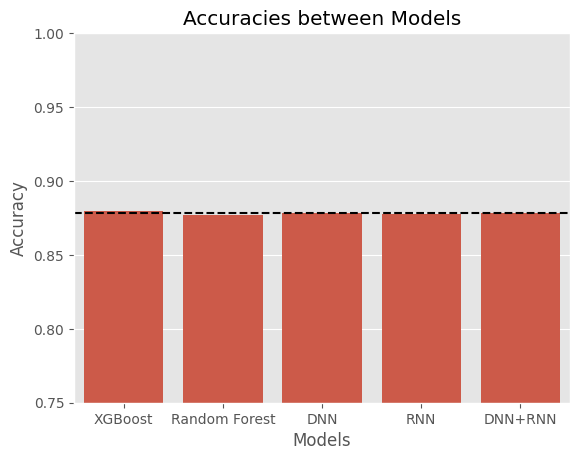

In [77]:
# Make a graph on all accuracies
accs_dict = {
    "XGBoost": [acc_xgb],
    "Random Forest": [acc_rf],
    "DNN": [accuracy],
    "RNN": [accuracy_2],
    "DNN+RNN": [accuracy_3]
}

accs_df = pd.DataFrame.from_dict(accs_dict, orient='index', columns=["Accuracies"])

ax = sns.barplot(data=accs_df, x=accs_df.index, y='Accuracies')

dnn_rnn_accuracy = accs_df.loc["DNN+RNN",:][0]
ax.axhline(y=dnn_rnn_accuracy, color='black', linestyle='--', label='DNN+RNN Accuracy')

plt.ylim(0.75, 1)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracies between Models")
plt.show()

> Comment: Surprisingly, The ensemble model did not show a huge improvement like we anticipated.

# Conclusion

In this project, we set out to develop predictive models for telecom customer churn. Our project included EDA, data preprocessing, and the training and evaluation of both ML and DL models.

The results of our efforts with ML models were successful, achieving good accuracy even in the challenging context of imbalanced data. These models established the foundation to compare the DL models.

However, DL models did not yield the expected performances. One of the key challenges was determining the most optimal deep learning architecture for our specific use case. DL models often require extensive hyperparameter tuning and architecture experimentation, which we were unable to fully explore in this project.

In conclusion, there are rooms for improvements in fine-tuning our DL models for better performances.
